# Discritizing Continuous Problems in Julia

In [1]:
using Distributions, LinearAlgebra, Random, StatsPlots, Optim, Plots

# Discritizing using Basis Functions

In [2]:
# The hat functions
function my_hats(x::Float64, center::Float64; spread=1)
    if x < (center-spread) || x > (center+spread)
        output = 0.0
    else
        output = 1.0 - (1/spread)*abs(x-center)
    end
    return output
end;

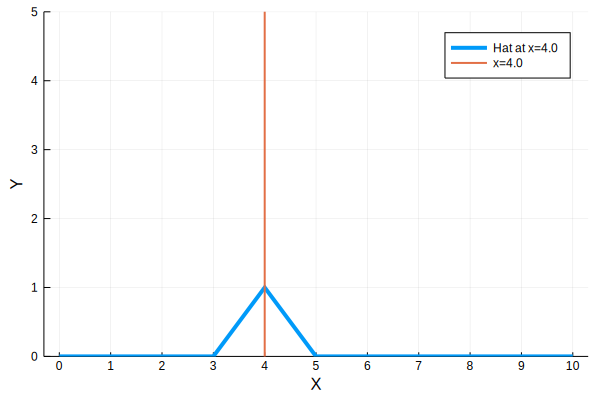

In [3]:
xvec = 0:0.01:10 # Vector just for plotting
plot(xvec,my_hats.(xvec,4.0),linewidth=4,ylimits=(0,5),xticks=(0:1:10),label="Hat at x=4.0")
vline!([4.0],linewidth=2,label="x=4.0",xlabel="X",ylabel="Y") # Vertical line

## Approximating Functions
We can use Hat functions to approximate other functions.

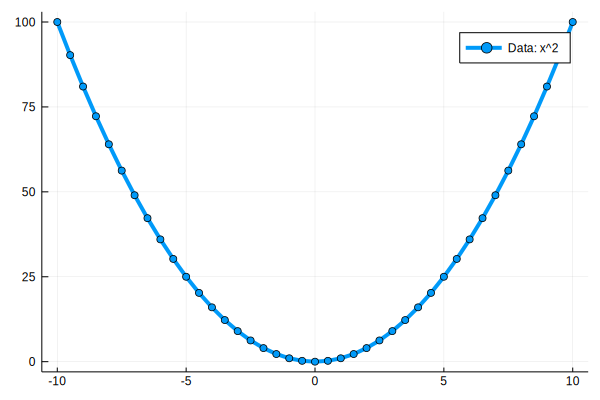

In [4]:
step = 0.5#<--- This sets the x step size for the entire problem
# step = 1.0
x = -10:step:10
y = x.^2
plot(x,y,linewidth=4,label="Data: x^2",marker=:circle)

We can plot the unscaled (raw) hats below by just interating over the necessary centers.

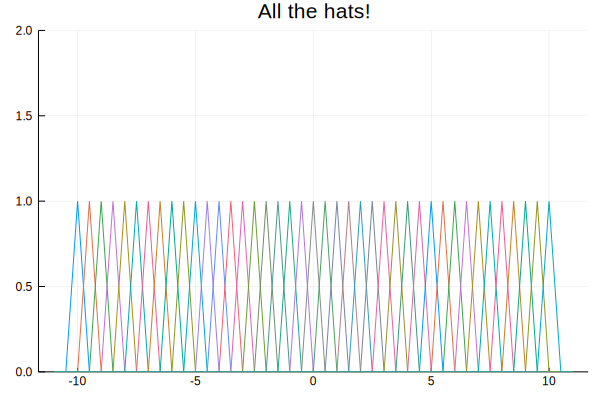

In [5]:
plt = plot(title="All the hats!",ylimits=(0,2),legend=false)
xvec = -11:0.1:11
for i in 1:length(y)
    plot!(plt,xvec,my_hats.(xvec,x[i]; spread=step))
end
plt

Now we can scale them appropriately.  Note, this is an artifical problem.  Here we know the TRUE value of $y$, since we made it!  Normally, this is not known.  The point of this is just to witness how amazingly accurate these hat functions can be, even with their very simple definition.

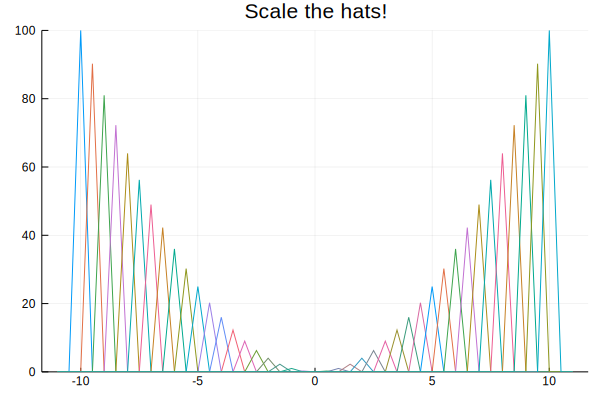

In [8]:
plt = plot(title="Scale the hats!",ylimits=(0,100),legend=false)
xvec = -11:0.1:11
for i in 1:length(y)
    plot!(plt,xvec,y[i] .* my_hats.(xvec,x[i]; spread=step))
end
plt

In [9]:
y

41-element Array{Float64,1}:
 100.0 
  90.25
  81.0 
  72.25
  64.0 
  56.25
  49.0 
  42.25
  36.0 
  30.25
  25.0 
  20.25
  16.0 
   ⋮   
  20.25
  25.0 
  30.25
  36.0 
  42.25
  49.0 
  56.25
  64.0 
  72.25
  81.0 
  90.25
 100.0 

While you can probably already see the parabola above, we really need to **sum** the hat functions.  This complex looking function below does just that.

In [10]:
g(val,x,y) = sum([y[i]*my_hats(val,x[i];spread=step) for i in 1:length(x)])

g (generic function with 1 method)

In [11]:
g(3.0123795,x,y) # We can evlauate the function for any arbitrary x value

9.080466750000003

Since we can add the hat functions, we can finally plot the true estimate of $f(x)$.

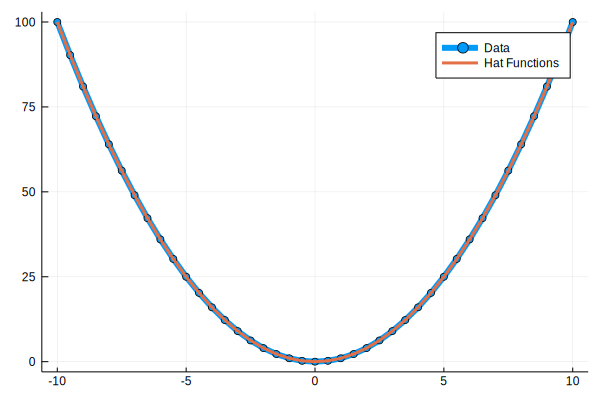

In [12]:
xvec = -10:0.1:10
hvec = zeros(length(xvec))
for i in 1:length(xvec)
    hvec[i] = g(xvec[i],x,y)
end

plot(x,y,linewidth=6,marker=:circle,label="Data")
plot!(xvec,hvec,linewidth=3,label="Hat Functions")

### Another Function
Doing everything again with another function: $x \sin(3x) $

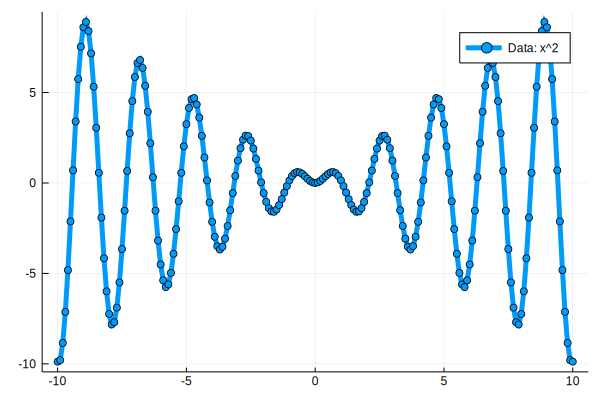

In [13]:
step = 0.1
x = -10:step:10
y = x .* sin.(3 .*x)
plot(x,y,linewidth=5,label="Data: x^2",marker=:circle)

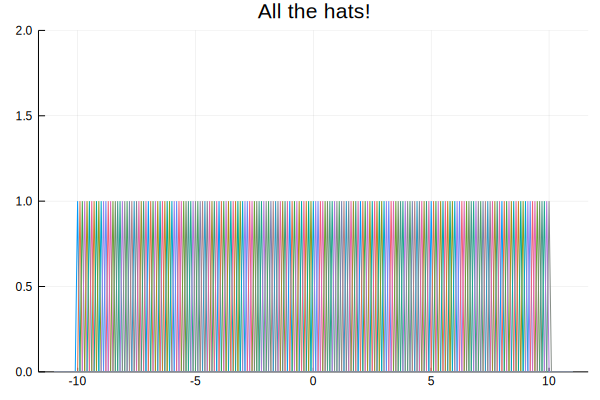

In [14]:
plt = plot(title="All the hats!",ylimits=(0,2),legend=false)
xvec = -11:0.1:11
for i in 1:length(y)
    plot!(plt,xvec,my_hats.(xvec,x[i]; spread=step))
end
plt

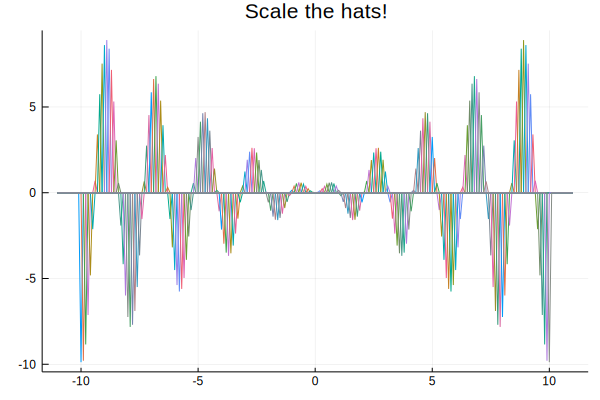

In [15]:
plt = plot(title="Scale the hats!",legend=false)
xvec = -11:0.1:11
for i in 1:length(y)
    plot!(plt,xvec,y[i] .* my_hats.(xvec,x[i];spread=step))
end
plt

In [16]:
g(z,x,v) = sum([v[i]*my_hats(z,x[i];spread=step) for i in 1:length(x)])

g (generic function with 1 method)

In [17]:
g(3.5,x,y)

-3.0789351599008397

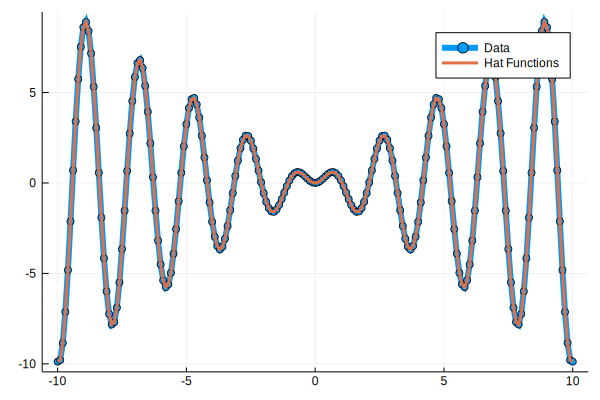

In [25]:
xvec = -10:0.1:10
hvec = zeros(length(xvec))
for i in 1:length(xvec)
    hvec[i] = g(xvec[i],x,y)
end

plot(x,y,linewidth=6,marker=:circle,label="Data")
plot!(xvec,hvec,linewidth=3,label="Hat Functions")

## Solving an unknown System

The examples above were totally artificial.  We used the exactly correct function to perfectly scale the hat functions.  Normally, that is not how it works.  If we have the real values of our unknown function, we should always just use those!

Here, we apply the method discussed in class to find a truly unknown function.  Yes, we have to assume it first to simulate some data, but that doesn't get used in the solution.  Later, however, we can use it to compare with our estimated values.

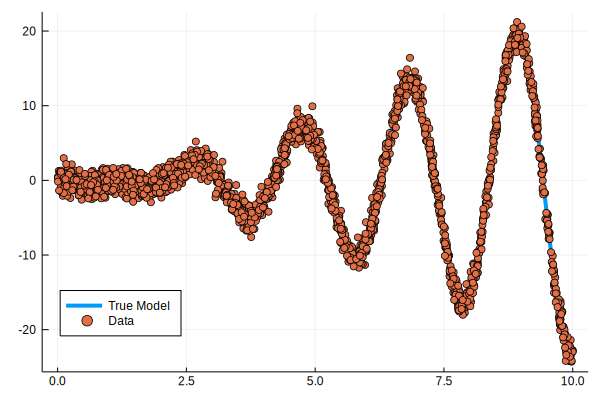

In [18]:
true_beta(x) = x * sin(3*x)
Random.seed!(1)
f(x) = true_beta(x)*log(x)
N = 2000
x = rand(Uniform(0,10),N)
y = f.(x) .+ rand(Normal(0,1),N)

xvec = 0:0.1:10
plot(xvec,f.(xvec),linewidth=4,label="True Model")
scatter!(x,y,label="Data",legend=:bottomleft)

Like before, we have to create our matrix operator before we can solve.

In [23]:
xmat = ones(N,1); #N by 1 vector 

In [24]:
step = 0.05
v = 0:step:10
for i in 1:length(v)
    xmat = hcat(xmat, my_hats.(x, v[i]; spread=step) .* log.(x) )
end
xmat

2000×202 Array{Float64,2}:
 1.0   0.0   0.0       0.0       0.0  …   0.0        0.0         0.0    
 1.0   0.0   0.0       0.0       0.0      0.0        0.0         0.0    
 1.0   0.0   0.0       0.0       0.0      0.0        0.0         0.0    
 1.0  -0.0  -1.06089  -1.47625  -0.0     -0.0       -0.0        -0.0    
 1.0   0.0   0.0       0.0       0.0      0.0        0.0         0.0    
 1.0   0.0   0.0       0.0       0.0  …   0.0        0.0         0.0    
 1.0   0.0   0.0       0.0       0.0      0.0        0.0         0.0    
 1.0   0.0   0.0       0.0       0.0      0.0        0.0439044   2.25859
 1.0   0.0   0.0       0.0       0.0      0.0        0.0         0.0    
 1.0   0.0   0.0       0.0       0.0      0.762917   0.0         0.0    
 1.0   0.0   0.0       0.0       0.0  …   0.0        0.0         0.0    
 1.0   0.0   0.0       0.0       0.0      0.0        0.0         0.0    
 1.0   0.0   0.0       0.0       0.0      0.0        0.0         0.0    
 ⋮                      

Now we can use the normal equations to solve for our estimated scalings of the hat functions

In [25]:
est_beta = inv(xmat' * xmat) * xmat' * y

202-element Array{Float64,1}:
   0.037905988856982466
  -0.012564114589168824
  -0.15141080549276173 
   0.3201009131835461  
  -0.1141922270168784  
   0.04165128750112384 
  -0.018067258874995856
   0.1947060674274818  
  -0.2695025516414415  
   0.5330167678090211  
   1.081118353378966   
   0.19397324623226894 
   0.5805672961514768  
   ⋮                   
  -0.6551566284605952  
  -2.318453228270093   
  -3.3623821650515655  
  -4.841948988185716   
  -6.132984821128659   
  -7.042960628289224   
  -8.114371280640263   
  -8.17152013075821    
  -9.720310040457585   
  -9.871429734925812   
 -10.139820394426305   
 -10.06020714948347    

In [26]:
g(z,x,v) = sum([v[i]*my_hats(z,x[i];spread=step) for i in 1:length(x)]);

In [27]:
g(5.5,v,est_beta[2:end])

-3.7802734934416935

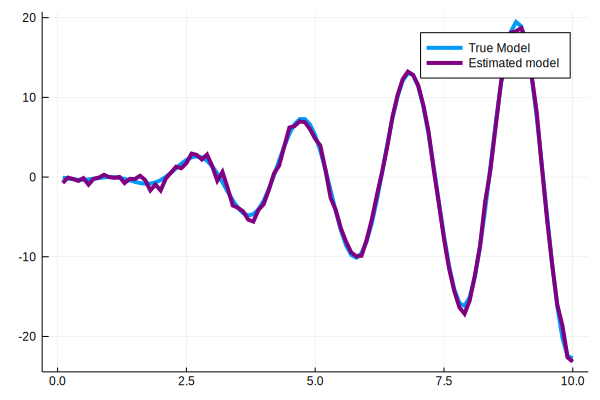

In [28]:
xvec = 0:0.1:10
hvec = zeros(length(xvec))
for i in 1:length(xvec)
    hvec[i] = g(xvec[i],v,est_beta[2:end])
end

xvec = 0:0.1:10
plot(xvec,f.(xvec),linewidth=4,label="True Model")
# scatter!(x,y,label="Data",legend=:bottomleft)
plot!(xvec,hvec .* log.(xvec),label="Estimated model",linewidth=4,color=:purple)

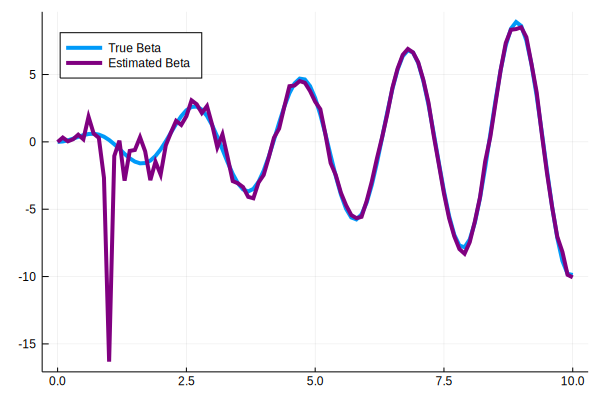

In [29]:
xvec = 0:0.1:10
plot(xvec,true_beta.(xvec),linewidth=4,label="True Beta",legend=:topleft)
plot!(xvec,hvec,label="Estimated Beta",linewidth=4,color=:purple)

# Discritizing using Numerical Integration (Quadrature)

Before we can look at discritizing using Numerical Integration (quadrature), let us first recall the simplest quadrature method: left riemann sums.

In [30]:
function my_left_riemann_sum(f,xspace)
    area = 0
    for i = 1:(length(xspace)-1)
        area += (xspace[i+1] - xspace[i])*f(xspace[i])
    end
    return area
end;

In [31]:
# Estimate the area under x^2 from 0 to 1, should be 1/3
step = 0.0001
x = 0:step:1
f(x) = x^2
my_left_riemann_sum(f,x)

0.33328333499999957

### Finding an Unknown function using Quadrature

We wish to find the function $f(x)$ in the following expression

$$ \int_a^b G(s,x) f(x) \ dx = d(s) ,$$

assuming that $G(s,x) = s x$, $a=1$, $b=10$, $s\in[1,10]$, and $d(s)$ is given.

To construct a $d(s)$, we will first assume a true $f(x)$, which will not be used in the problem solving.  Let us assume $f(x) = -5 \sin(x)$. 

In [33]:
# First, make a fake d(s) for our problem to then invert
Sstep = 0.01
s = (Sstep):Sstep:10
Xstep = 0.5
x = (Xstep):Xstep:10

noise = Normal(0,20)

G(s,x) = s*x
true_f(x) = -5*sin(x)

ds = zeros(length(s))
for i = 1:length(ds)
    ds[i] = my_left_riemann_sum(z -> G(s[i],z)*true_f(z),x) + rand(noise)
end

1000-element Array{Float64,1}:
   -3.6697694473312676
  -34.951569504239664 
  -20.522427194893652 
   20.59263478183386  
  -20.42899842656214  
  -14.09809065031255  
  -12.952111006002813 
  -15.447961473571125 
   20.945858148110513 
   -9.539966710708644 
    9.35754139064841  
  -16.252491733446853 
   -1.4965935122736047
    ⋮                 
 -452.9179579622971   
 -444.51232142074485  
 -433.62741446286367  
 -429.3959887540867   
 -436.26698290226875  
 -432.12718493960125  
 -456.71930107138195  
 -467.7073750376729   
 -434.03675417717415  
 -475.6622083775372   
 -440.07498652794413  
 -452.1947737908801   

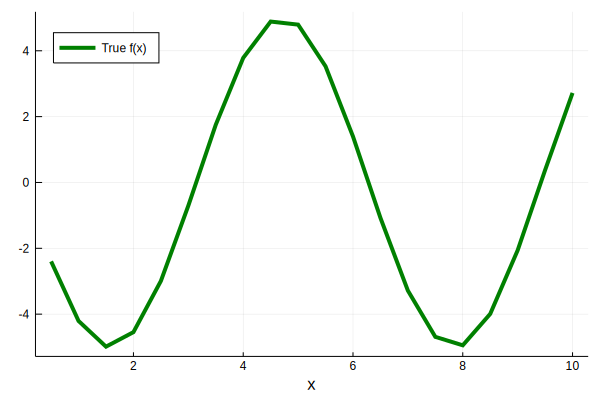

In [34]:
plot(x,true_f.(x),linewidth=4,label="True f(x)",xlabel="x",color=:green,legend=:topleft)

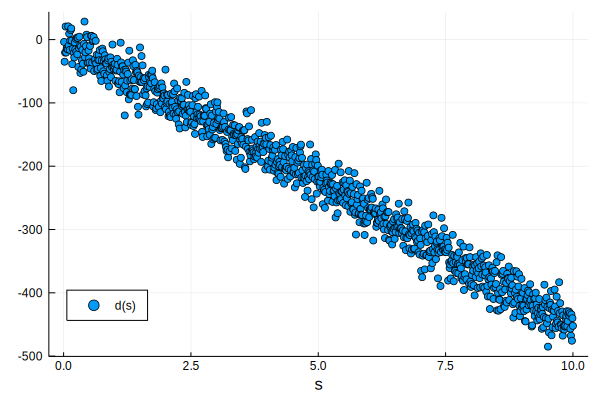

In [35]:
scatter(s,ds,linewidth=4,label="d(s)",xlabel="s",legend=:bottomleft)

Because we wish to estimate the integral

$$ \int_a^b G(s,x) f(x) \ dx = d(s) ,$$

we can use numerical integration (quadrature) to discritize the continuous problem into

$$\sum_{j=1}^M G_{i,j} f_j \Delta x = d_i,$$ 

where $G_{i,j} = G(s_i,x_j)$, $f_j = f(x_j)$, and $d_i = d(s_i)$.  This essentially breaks the problem into $i$ sized parts, where each one requires a sum.  By a slight adjustment of our perspective, we might recognize that this is a Matrix equation, specifically of the form

$$ \Delta x \begin{bmatrix} G_{1,1} & G_{1,2} & \cdots & G_{1,M} \\
                   G_{2,1} & G_{2,2} & \cdots & G_{2,M} \\
                   \vdots & \vdots & \ddots & \vdots \\
                   G_{N,1} & G_{N,2} & \cdots & G_{N,M}
                   \end{bmatrix}
    \begin{bmatrix} f_1 \\ f_2 \\ \vdots \\ f_M \end{bmatrix}
    =
    \begin{bmatrix} d_1 \\ d_2 \\ \vdots \\ d_N \end{bmatrix} ,$$
    
where the $\Delta x$ is a scalar number that can be pulled out front.  What's nice about this is - We already know how to solve matrix equations!

In [36]:
# Construct the G matrix
Gij = [G(si,xj)*Xstep for si in s, xj in x]

1000×20 Array{Float64,2}:
 0.0025  0.005  0.0075   0.01   0.0125  …   0.0425   0.045   0.0475   0.05
 0.005   0.01   0.015    0.02   0.025       0.085    0.09    0.095    0.1 
 0.0075  0.015  0.0225   0.03   0.0375      0.1275   0.135   0.1425   0.15
 0.01    0.02   0.03     0.04   0.05        0.17     0.18    0.19     0.2 
 0.0125  0.025  0.0375   0.05   0.0625      0.2125   0.225   0.2375   0.25
 0.015   0.03   0.045    0.06   0.075   …   0.255    0.27    0.285    0.3 
 0.0175  0.035  0.0525   0.07   0.0875      0.2975   0.315   0.3325   0.35
 0.02    0.04   0.06     0.08   0.1         0.34     0.36    0.38     0.4 
 0.0225  0.045  0.0675   0.09   0.1125      0.3825   0.405   0.4275   0.45
 0.025   0.05   0.075    0.1    0.125       0.425    0.45    0.475    0.5 
 0.0275  0.055  0.0825   0.11   0.1375  …   0.4675   0.495   0.5225   0.55
 0.03    0.06   0.09     0.12   0.15        0.51     0.54    0.57     0.6 
 0.0325  0.065  0.0975   0.13   0.1625      0.5525   0.585   0.6175   0.65

In [37]:
# Use the normal equations to solve for f_i!
est_f = inv(Gij' * Gij) * Gij' * ds

SingularException: SingularException(4)

This system is not directly solvable.  The normal equations will not work.  Instead, we can try to find a solution using ordinary least squares (remember, the normal equations are trying to solve this same problem) and numerical optimization.

In [38]:
# This is our squared error function
g(x) = sum( (Gij*x - ds).^2 );

In [39]:
g(ones(length(x)))

3.1886664602862984e8

In [40]:
# Use the optim package to get a solution
# out = optimize(g,ones(length(x)), BFGS(); autodiff = :forward)
out = optimize(g,sin.(x), BFGS(); autodiff = :forward)

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [4.08e-01, 6.98e-01, 7.82e-01,  ...]
    Minimum:   4.001507e+05

 * Found with
    Algorithm:     BFGS
    Initial Point: [4.79e-01, 8.41e-01, 9.97e-01,  ...]

 * Convergence measures
    |x - x'|               = 1.19e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.03e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.16e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.91e-16 ≰ 0.0e+00
    |g(x)|                 = 1.26e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    2
    f(x) calls:    6
    ∇f(x) calls:   6


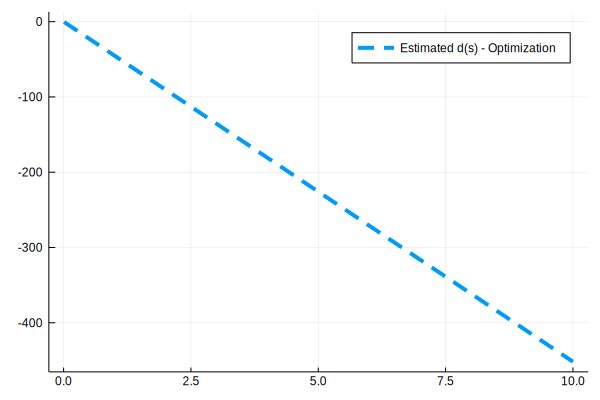

In [41]:
est_d = Gij*out.minimizer

# scatter(s,ds,linewidth=5,label="True d(s)")
plot(s,est_d,linewidth=4,linestyle=:dash,label="Estimated d(s) - Optimization")

The plot of the estimated $d(s)$, which was found via OLS using numerical optimization looks great!  This just means we are able to reproduce the data.  However, that was not the main point of this problem.  We instead wanted to estimate the unknown function $f(x)$ that was buried inside the integral.  Let's compare that:

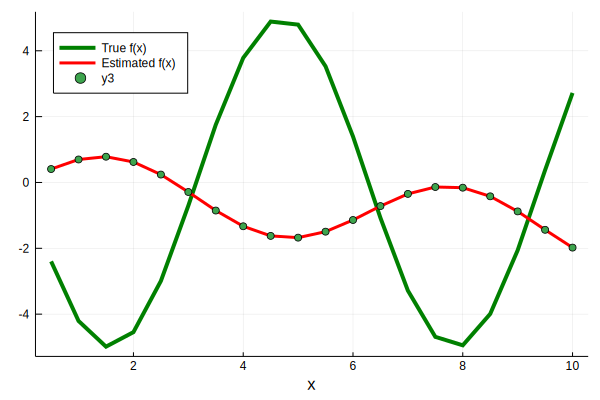

In [42]:
plot(x,true_f.(x),linewidth=4,label="True f(x)",xlabel="x",color=:green,legend=:topleft)
plot!(x,out.minimizer,linewidth=3,label="Estimated f(x)", color=:red)
scatter!(x, out.minimizer)

We do very poorly on this fit.  The reasons are that this problem, in general, is ill-posed.  There is NOT one unique function $f(x)$ that is able to generate the correct output.  Asking to solve this problem, in some sense, is just the **wrong** thing to do.  Still, it is the object of our interest.